In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.experimental.optimizers as optimizers
import jax.random as jr
import jax.numpy as np
from jax import jit, value_and_grad
from tqdm.auto import trange
import matplotlib.pyplot as plt

from ssm.models.hmm.gaussian_hmm import make_gaussian_hmm
from ssm.inference.core import hmm_log_normalizer, hmm_expected_states
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
from ssm.inference.em.hmm import em
import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

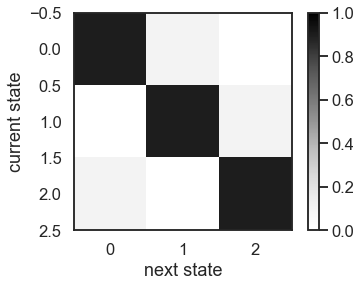

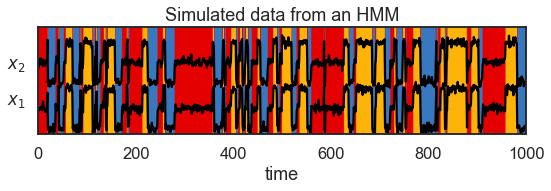

In [3]:
transition_matrix = 0.9 * np.eye(3) \
                    + 0.1 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3

true_hmm = make_gaussian_hmm(
    num_states=3, 
    emission_dim=2,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_scale_trils=0.25 * np.eye(2))

states, data = true_hmm.sample(jr.PRNGKey(0), 1000)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()

plot_transition_matrix(transition_matrix)
plot_hmm_data(data, states)

## Fit Gaussian HMM using hmm_log_normalizer

100%|██████████| 1000/1000 [00:01<00:00, 722.12it/s]


Text(0, 0.5, 'objective')

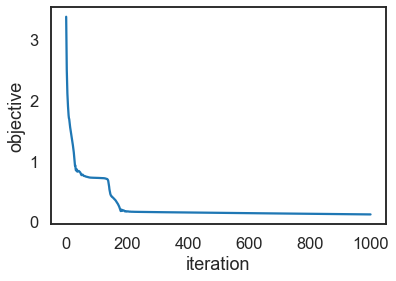

In [4]:
seed = jr.PRNGKey(1)
learning_rate = 0.1

num_states_est = 3
emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
hmm = make_gaussian_hmm(num_states_est, 2, 
                        transition_logits=np.zeros((num_states_est, num_states_est)), 
                        emission_means=emission_means)

def objective(hmm):
    lp = hmm_log_normalizer(*hmm.natural_parameters(data))
    return -lp / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(hmm)

@jit
def step(step, opt_state):
  value, grads = value_and_grad(objective)(get_params(opt_state))
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

vals = []
for i in trange(1000):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals)
plt.xlabel("iteration")
plt.ylabel("objective")

In [5]:
fitted_hmm = get_params(opt_state)
Z, (Ez0, Ezzp1, Ez) = hmm_expected_states(*fitted_hmm.natural_parameters(data))
perm = find_permutation(states, np.argmax(Ez, axis=-1))

True transition matrix


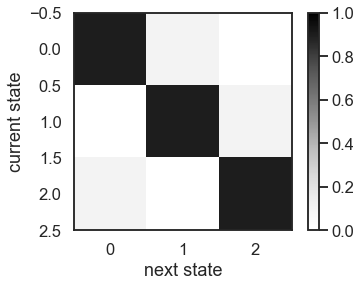

Estimated transition matrix


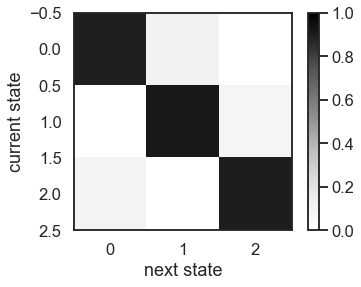

In [6]:
print("True transition matrix")
plot_transition_matrix(true_hmm.transition_matrix)

print("Estimated transition matrix")
plot_transition_matrix(fitted_hmm.transition_matrix[:, perm][perm, :])

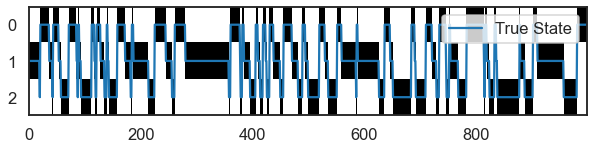

In [7]:
plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.legend()
plt.show()

## Fit HMM using EM

[converged] LP: -363.582:  14%|█▍        | 14/100 [00:01<00:10,  8.34it/s]


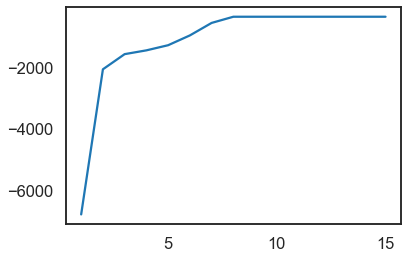

In [8]:
seed = jr.PRNGKey(1)
learning_rate = 0.05

num_states_est = 3
emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
hmm = make_gaussian_hmm(num_states_est, 2, 
                        transition_logits=np.zeros((num_states_est, num_states_est)), 
                        emission_means=emission_means)

log_probs, fitted_hmm, posterior = em(hmm, data)

plt.plot(log_probs)
plt.show()

In [9]:
Z, (Ez0, Ezzp1, Ez) = hmm_expected_states(*fitted_hmm.natural_parameters(data))
perm = find_permutation(states, np.argmax(Ez, axis=-1))

True transition matrix


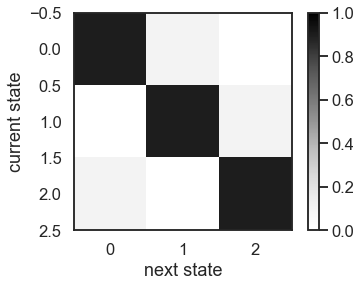

Estimated transition matrix


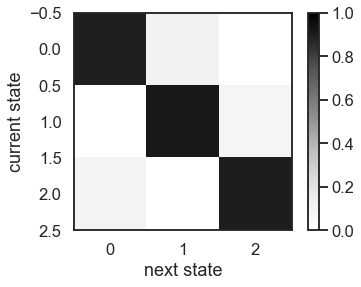

In [10]:
print("True transition matrix")
plot_transition_matrix(true_hmm.transition_matrix)

print("Estimated transition matrix")
plot_transition_matrix(fitted_hmm.transition_matrix[:, perm][perm, :])

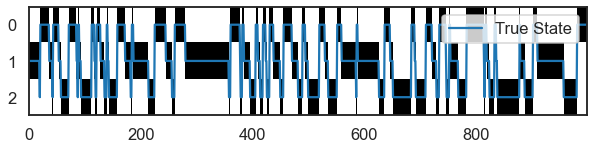

In [11]:
plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.legend()
plt.show()

# Poisson HMM

In [12]:
from ssm.models.hmm.poisson_hmm import make_poisson_hmm, initialize_poisson_hmm

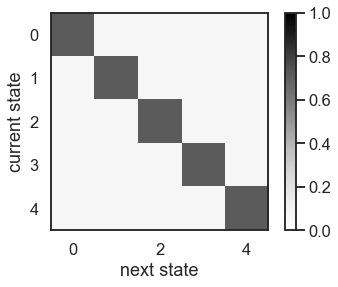

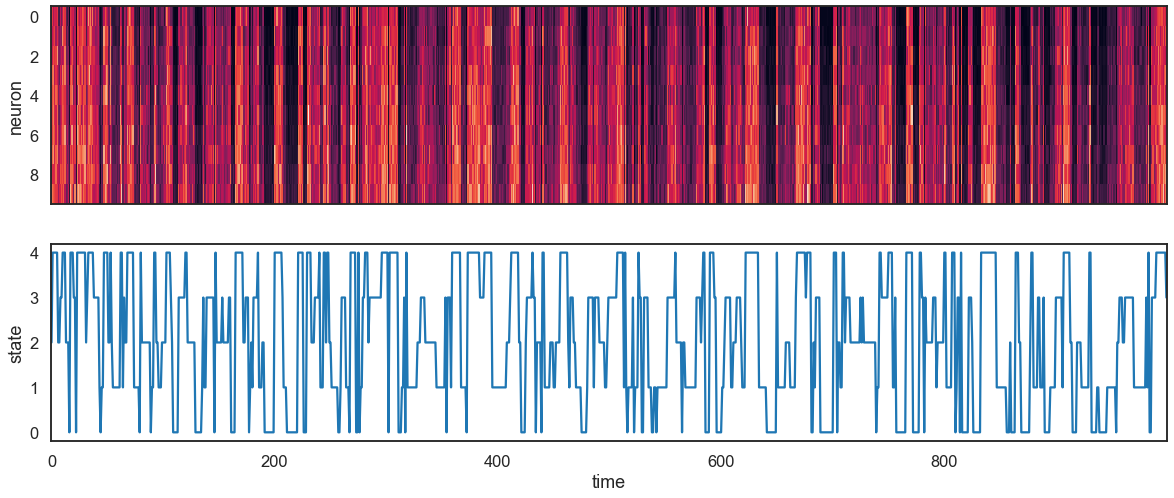

In [13]:

num_states = 5
num_channels = 10
# transition_matrix = 0.95 * np.eye(num_states) + 0.05 * np.roll(np.eye(num_states), 1, axis=1)
transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states))
emission_rates = np.arange(0, num_states * num_channels, dtype=np.float32).reshape((num_states, num_channels))
emission_rates += 1

poisson_hmm = make_poisson_hmm(num_states, num_channels, transition_matrix=transition_matrix, emission_log_rates=np.log(emission_rates))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    states, data = poisson_hmm.sample(jr.PRNGKey(0), 1000)

plot_transition_matrix(poisson_hmm.transition_matrix)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("neuron")
axs[1].plot(states)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

[converged] LP: -30082.598:  16%|█▌        | 16/100 [00:01<00:07, 10.64it/s]


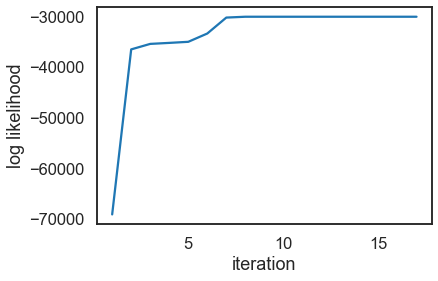

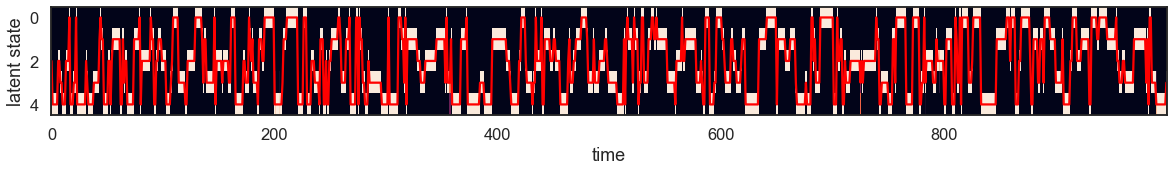

In [14]:
test_hmm = initialize_poisson_hmm(jr.PRNGKey(1), num_states, data)
lps, test_hmm, posterior = em(test_hmm, data, m_step_type="exact", num_iters=100)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Posterior distribution
perm = find_permutation(states, np.argmax(posterior.expected_states, axis=-1))
plt.figure(figsize=(20, 2))
plt.imshow(posterior.expected_states.T[perm], aspect="auto", interpolation="none")
plt.plot(states, '-r')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()

100%|██████████| 10000/10000 [00:05<00:00, 1969.39it/s]


Text(0, 0.5, 'objective')

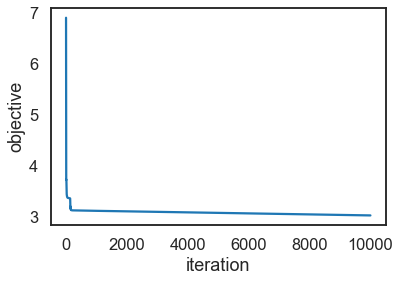

In [15]:
seed = jr.PRNGKey(1)
learning_rate = 0.1

test_hmm = initialize_poisson_hmm(jr.PRNGKey(1), num_states, data)

def objective(hmm):
    lp = hmm_log_normalizer(*hmm.natural_parameters(data))
    return -lp / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(test_hmm)

@jit
def step(step, opt_state):
  value, grads = value_and_grad(objective)(get_params(opt_state))
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

vals = []
for i in trange(10000):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals)
plt.xlabel("iteration")
plt.ylabel("objective")

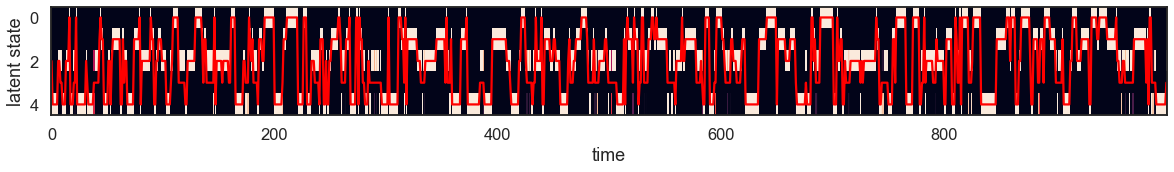

In [16]:
# Posterior distribution
fitted_hmm = get_params(opt_state)
Z, (Ez0, Ezzp1, Ez) = hmm_expected_states(*fitted_hmm.natural_parameters(data))
perm = find_permutation(states, np.argmax(posterior.expected_states, axis=-1))
plt.figure(figsize=(20, 2))
plt.imshow(Ez.T[perm], aspect="auto", interpolation="none")
plt.plot(states, '-r')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()